<a href="https://colab.research.google.com/github/Deepansh1106/Deepansh1106/blob/main/Food_Delivery_Time_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Importing important Libraries***

In [283]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statistics
import pickle
from geopy.distance import geodesic


from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [284]:
df = pd.read_csv('ZomatoModel.csv')

Data Preprocessing and Analysis

In [285]:

df.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30


In [286]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45593 non-null  object 
 1   Delivery_person_ID           45593 non-null  object 
 2   Delivery_person_Age          45593 non-null  object 
 3   Delivery_person_Ratings      45593 non-null  object 
 4   Restaurant_latitude          45593 non-null  float64
 5   Restaurant_longitude         45593 non-null  float64
 6   Delivery_location_latitude   45593 non-null  float64
 7   Delivery_location_longitude  45593 non-null  float64
 8   Order_Date                   45593 non-null  object 
 9   Time_Orderd                  45593 non-null  object 
 10  Time_Order_picked            45593 non-null  object 
 11  Weatherconditions            45593 non-null  object 
 12  Road_traffic_density         45593 non-null  object 
 13  Vehicle_conditio

In [287]:

df.shape

(45593, 20)

In [288]:
df.isnull().sum()

,0
ID,0
Delivery_person_ID,0
Delivery_person_Age,0
Delivery_person_Ratings,0
Restaurant_latitude,0
Restaurant_longitude,0
Delivery_location_latitude,0
Delivery_location_longitude,0
Order_Date,0
Time_Orderd,0


In [289]:
df.describe()

,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Vehicle_condition
count,45593.000000,45593.000000,45593.000000,45593.000000,45593.000000
mean,17.017729,70.231332,17.465186,70.845702,1.023359
std,8.185109,22.883647,7.335122,21.118812,0.839065
min,-30.905562,-88.366217,0.010000,0.010000,0.000000
25%,12.933284,73.170000,12.988453,73.280000,0.000000
50%,18.546947,75.898497,18.633934,76.002574,1.000000
75%,22.728163,78.044095,22.785049,78.107044,2.000000
max,30.914057,88.433452,31.054057,88.563452,3.000000


In [290]:
df.columns

Index(['ID', 'Delivery_person_ID', 'Delivery_person_Age',
       'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Order_Date', 'Time_Orderd',
       'Time_Order_picked', 'Weatherconditions', 'Road_traffic_density',
       'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle',
       'multiple_deliveries', 'Festival', 'City', 'Time_taken(min)'],
      dtype='object')

**We are going to add these columns: ('Time_taken(min)', 'Weather_conditions', 'City_code') to get the meaningful data in efficient way.**


In [291]:
def extract_column_value(df):
    # Ensure 'Time_taken(min)' is a string and then convert to int
    df['Time_taken'] = df['Time_taken(min)'].apply(lambda x: int(str(x).split(' ')[1].strip()) if isinstance(x, str) else x)

    # Ensure 'Weatherconditions' is a string before splitting
    df['Weather_conditions'] = df['Weatherconditions'].apply(lambda x: str(x).split(' ')[1].strip() if isinstance(x, str) else x)

    # Ensure 'Delivery_person_ID' is a string before splitting
    df['City_code'] = df['Delivery_person_ID'].astype(str).str.split("RES", expand=True)[0]

    return df  # <-- IMPORTANT

# Call the function and capture the result
df = extract_column_value(df)

# Now safely drop unneeded columns
df.drop(['Weatherconditions', 'ID', 'Delivery_person_ID'], axis=1, inplace=True)

# Check the result
df.head()


,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),Time_taken,Weather_conditions,City_code
0,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,High,2,Snack,motorcycle,0,No,Urban,(min) 24,24,Sunny,INDO
1,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33,33,Stormy,BANG
2,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26,26,Sandstorms,BANG
3,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21,21,Sunny,COIMB
4,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,High,1,Snack,scooter,1,No,Metropolitian,(min) 30,30,Cloudy,CHEN


In [292]:

df.head()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),Time_taken,Weather_conditions,City_code
0,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,High,2,Snack,motorcycle,0,No,Urban,(min) 24,24,Sunny,INDO
1,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33,33,Stormy,BANG
2,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26,26,Sandstorms,BANG
3,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21,21,Sunny,COIMB
4,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,High,1,Snack,scooter,1,No,Metropolitian,(min) 30,30,Cloudy,CHEN


In [293]:
df.columns

Index(['Delivery_person_Age', 'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Order_Date', 'Time_Orderd',
       'Time_Order_picked', 'Road_traffic_density', 'Vehicle_condition',
       'Type_of_order', 'Type_of_vehicle', 'multiple_deliveries', 'Festival',
       'City', 'Time_taken(min)', 'Time_taken', 'Weather_conditions',
       'City_code'],
      dtype='object')

In [294]:
df.duplicated()

,0
0,False
1,False
2,False
3,False
4,False
...,...
45588,False
45589,False
45590,False
45591,False


In [295]:
df['Delivery_person_Age'] = df['Delivery_person_Age'].astype('float64')
df['Delivery_person_Ratings'] = df['Delivery_person_Ratings'].astype('float64')
df['multiple_deliveries'] = df['multiple_deliveries'].astype('float64')
df['Order_Date']=pd.to_datetime(df['Order_Date'],format="%d-%m-%Y")

In [296]:
df.replace('NaN', float(np.nan), inplace=True)

In [297]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Delivery_person_Age          43739 non-null  float64       
 1   Delivery_person_Ratings      43685 non-null  float64       
 2   Restaurant_latitude          45593 non-null  float64       
 3   Restaurant_longitude         45593 non-null  float64       
 4   Delivery_location_latitude   45593 non-null  float64       
 5   Delivery_location_longitude  45593 non-null  float64       
 6   Order_Date                   45593 non-null  datetime64[ns]
 7   Time_Orderd                  45593 non-null  object        
 8   Time_Order_picked            45593 non-null  object        
 9   Road_traffic_density         45593 non-null  object        
 10  Vehicle_condition            45593 non-null  int64         
 11  Type_of_order                45593 non-nu

In [298]:
df.isnull().sum().sort_values(ascending=False)


,0
Delivery_person_Ratings,1908
Delivery_person_Age,1854
multiple_deliveries,993
Weather_conditions,616
Restaurant_longitude,0
Restaurant_latitude,0
Delivery_location_latitude,0
Delivery_location_longitude,0
Time_Order_picked,0
Road_traffic_density,0


In [299]:
#handle null values
df['Delivery_person_Age'].fillna(np.random.choice(df['Delivery_person_Age']), inplace=True)
df['Weather_conditions'].fillna(np.random.choice(df['Weather_conditions']), inplace=True)
df['City'].fillna(df['City'].mode()[0], inplace=True)
df['Festival'].fillna(df['Festival'].mode()[0], inplace=True)
df['multiple_deliveries'].fillna(df['multiple_deliveries'].mode()[0], inplace=True)
df['Road_traffic_density'].fillna(df['Road_traffic_density'].mode()[0], inplace=True)
df['Delivery_person_Ratings'].fillna(df['Delivery_person_Ratings'].median(), inplace=True)

**Time Series Analysis**

In [300]:
df["day"] = df.Order_Date.dt.day
df["month"] = df.Order_Date.dt.month
df["quarter"] = df.Order_Date.dt.quarter
df["year"] = df.Order_Date.dt.year
df['day_of_week'] = df.Order_Date.dt.day_of_week.astype(int)
df["is_month_start"] = df.Order_Date.dt.is_month_start.astype(int)
df["is_month_end"] = df.Order_Date.dt.is_month_end.astype(int)
df["is_quarter_start"] = df.Order_Date.dt.is_quarter_start.astype(int)
df["is_quarter_end"] = df.Order_Date.dt.is_quarter_end.astype(int)
df["is_year_start"] = df.Order_Date.dt.is_year_start.astype(int)
df["is_year_end"] = df.Order_Date.dt.is_year_end.astype(int)
df['is_weekend'] = np.where(df['day_of_week'].isin([5,6]),1,0)

In [301]:
df.head()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Road_traffic_density,...,quarter,year,day_of_week,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_weekend
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,High,...,1,2022,5,0,0,0,0,0,0,1
1,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,19:50:00,Jam,...,1,2022,4,0,0,0,0,0,0,0
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,08:45:00,Low,...,1,2022,5,0,0,0,0,0,0,1
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,18:00:00,18:10:00,Medium,...,2,2022,1,0,0,0,0,0,0,0
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,13:45:00,High,...,1,2022,5,0,0,0,0,0,0,1


In [302]:
df.isnull().sum()

,0
Delivery_person_Age,0
Delivery_person_Ratings,0
Restaurant_latitude,0
Restaurant_longitude,0
Delivery_location_latitude,0
Delivery_location_longitude,0
Order_Date,0
Time_Orderd,0
Time_Order_picked,0
Road_traffic_density,0


In [303]:
print(df['Time_Orderd'].unique())

['11:30:00' '19:45:00' '08:30:00' '18:00:00' '13:30:00' '21:20:00'
 '19:15:00' '17:25:00' '20:55:00' '21:55:00' '14:55:00' '17:30:00'
 '09:20:00' '19:50:00' '20:25:00' '20:30:00' '20:40:00' '21:15:00'
 '20:20:00' '22:30:00' '08:15:00' '19:30:00' '12:25:00' '18:35:00'
 '20:35:00' '23:20:00' '23:35:00' '22:35:00' '23:25:00' '13:35:00'
 '21:35:00' '18:55:00' '14:15:00' '11:00:00' '09:45:00' '08:40:00'
 '23:00:00' 'NaN ' '19:10:00' '10:55:00' '21:40:00' '19:00:00' '16:45:00'
 '15:10:00' '22:45:00' '22:10:00' '20:45:00' '22:50:00' '17:55:00'
 '09:25:00' '20:15:00' '22:25:00' '22:40:00' '23:50:00' '15:25:00'
 '10:20:00' '10:40:00' '15:55:00' '20:10:00' '12:10:00' '15:30:00'
 '10:35:00' '21:10:00' '20:50:00' '12:35:00' '21:00:00' '23:40:00'
 '18:15:00' '18:20:00' '11:45:00' '12:45:00' '23:30:00' '10:50:00'
 '21:25:00' '10:10:00' '17:50:00' '22:20:00' '12:40:00' '23:55:00'
 '10:25:00' '08:45:00' '23:45:00' '19:55:00' '22:15:00' '23:10:00'
 '09:15:00' '18:25:00' '18:45:00' '16:50:00' '00:00:00'

In [304]:
mask = df['Time_Orderd'].isna()
mask[mask==True]

,Time_Orderd


In [305]:
# Convert to timedelta (also handles 'NaN' or invalid formats as NaT)
df['Time_Orderd'] = pd.to_timedelta(df['Time_Orderd'], errors='coerce')

# Now fill the NaNs using the median of timedelta values
df['Time_Orderd'].fillna(df['Time_Orderd'].median(), inplace=True)

In [306]:
mask = df['Time_Orderd'].isna()
mask[mask==True]

,Time_Orderd


In [307]:
# Convert Order_Date to datetime if it's not already
df['Order_Date'] = pd.to_datetime(df['Order_Date'])

# Convert the 'Time_Orderd' and 'Time_Order_picked' columns to timedelta (duration)
df['Time_Orderd'] = pd.to_timedelta(df['Time_Orderd'])
df['Time_Order_picked'] = pd.to_timedelta(df['Time_Order_picked'])

# Create formatted time columns as datetime objects
df['Time_Ordered_formatted'] = df['Order_Date'] + df['Time_Orderd']

df['Time_Order_picked_formatted'] = df['Order_Date'] + np.where(
    df['Time_Order_picked'] < df['Time_Orderd'],
    pd.DateOffset(days=1),
    pd.DateOffset(days=0)) + df['Time_Order_picked']

# Make sure that the new columns are of datetime type
df['Time_Ordered_formatted'] = pd.to_datetime(df['Time_Ordered_formatted'])
df['Time_Order_picked_formatted'] = pd.to_datetime(df['Time_Order_picked_formatted'])

# Now calculate the order preparation time in minutes
df['order_prepare_time'] = (df['Time_Order_picked_formatted'] - df['Time_Ordered_formatted']).dt.total_seconds() / 60

# Handle null values by filling with the median
df['order_prepare_time'].fillna(df['order_prepare_time'].median(), inplace=True)

# Check the first few rows
df[['Time_Ordered_formatted', 'Time_Order_picked_formatted', 'order_prepare_time']].head()

,Time_Ordered_formatted,Time_Order_picked_formatted,order_prepare_time
0,2022-03-19 11:30:00,2022-03-19 11:45:00,15.0
1,2022-03-25 19:45:00,2022-03-25 19:50:00,5.0
2,2022-03-19 08:30:00,2022-03-19 08:45:00,15.0
3,2022-04-05 18:00:00,2022-04-05 18:10:00,10.0
4,2022-03-26 13:30:00,2022-03-26 13:45:00,15.0


In [308]:
df.drop(['Time_Orderd', 'Time_Order_picked', 'Time_Ordered_formatted', 'Time_Order_picked_formatted', 'Order_Date','Time_taken'], axis=1, inplace=True)


In [265]:
# Initialize the 'distance' column with zeros
df['distance'] = np.zeros(len(df))

# Get the restaurant and delivery location coordinates as numpy arrays
restaurant_coordinates = df[['Restaurant_latitude', 'Restaurant_longitude']].to_numpy()
delivery_location_coordinates = df[['Delivery_location_latitude', 'Delivery_location_longitude']].to_numpy()

# Calculate the geodesic distance between each restaurant and delivery location
df['distance'] = np.array([
    geodesic(restaurant, delivery).kilometers
    for restaurant, delivery in zip(restaurant_coordinates, delivery_location_coordinates)
])



In [266]:
df = df[df['distance'] < 100]  # ✅ Completely overwrite with filtered rows



In [267]:
df['distance'].head()

,distance
0,3.020737
1,20.143737
2,1.549693
3,7.774497
4,6.197898


In [268]:
df.shape

(45162, 30)

In [269]:
df['distance'].describe()

,distance
count,45162.000000
mean,9.718912
std,5.599114
min,1.463837
25%,4.654105
50%,9.203901
75%,13.660195
max,20.942906


**DATA VISUALIZATION**

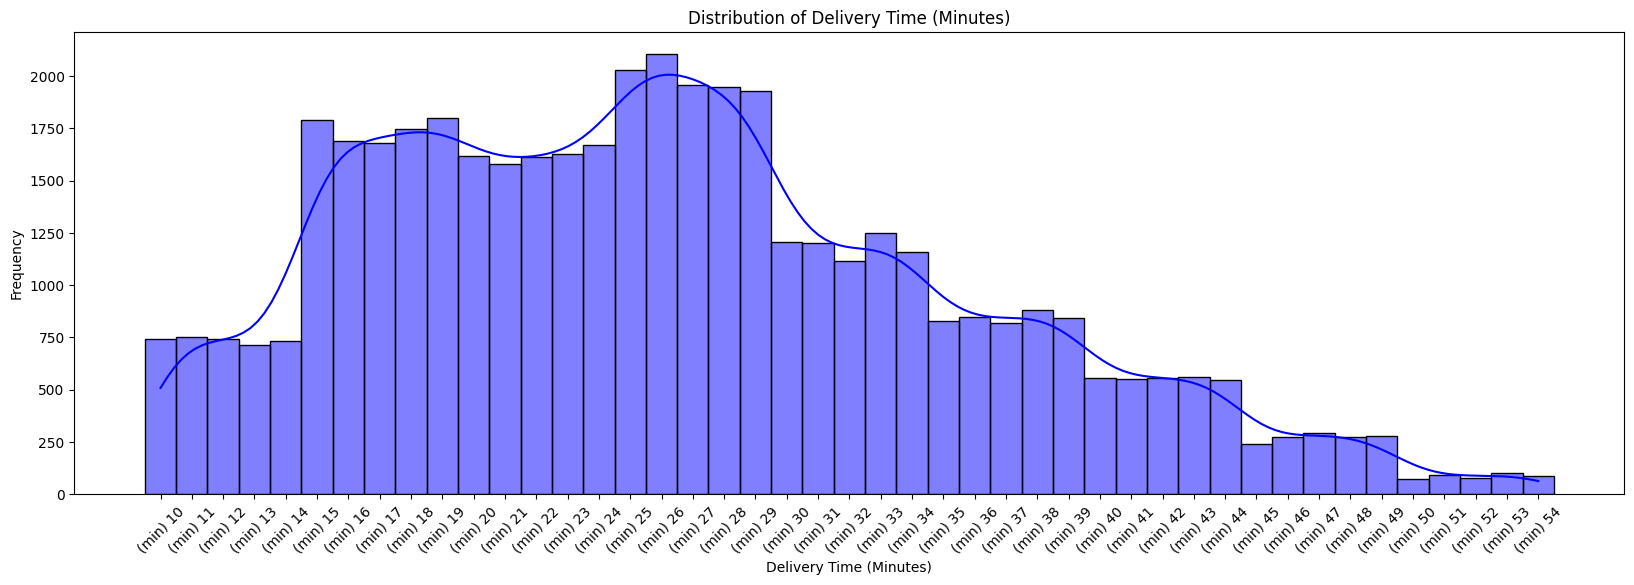

In [270]:
df_sorted = df.sort_values(by='Time_taken(min)', ascending=True)

# Plot the distribution using the sorted dataframe
plt.figure(figsize=(20, 6))
sns.histplot(df_sorted['Time_taken(min)'], kde=True, color='blue')
plt.title('Distribution of Delivery Time (Minutes)')
plt.xlabel('Delivery Time (Minutes)')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.locator_params(axis='x', nbins=10)
plt.show()

In [271]:
df.columns

Index(['Delivery_person_Age', 'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Road_traffic_density',
       'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle',
       'multiple_deliveries', 'Festival', 'City', 'Time_taken(min)',
       'Weather_conditions', 'City_code', 'day', 'month', 'quarter', 'year',
       'day_of_week', 'is_month_start', 'is_month_end', 'is_quarter_start',
       'is_quarter_end', 'is_year_start', 'is_year_end', 'is_weekend',
       'order_prepare_time', 'distance'],
      dtype='object')

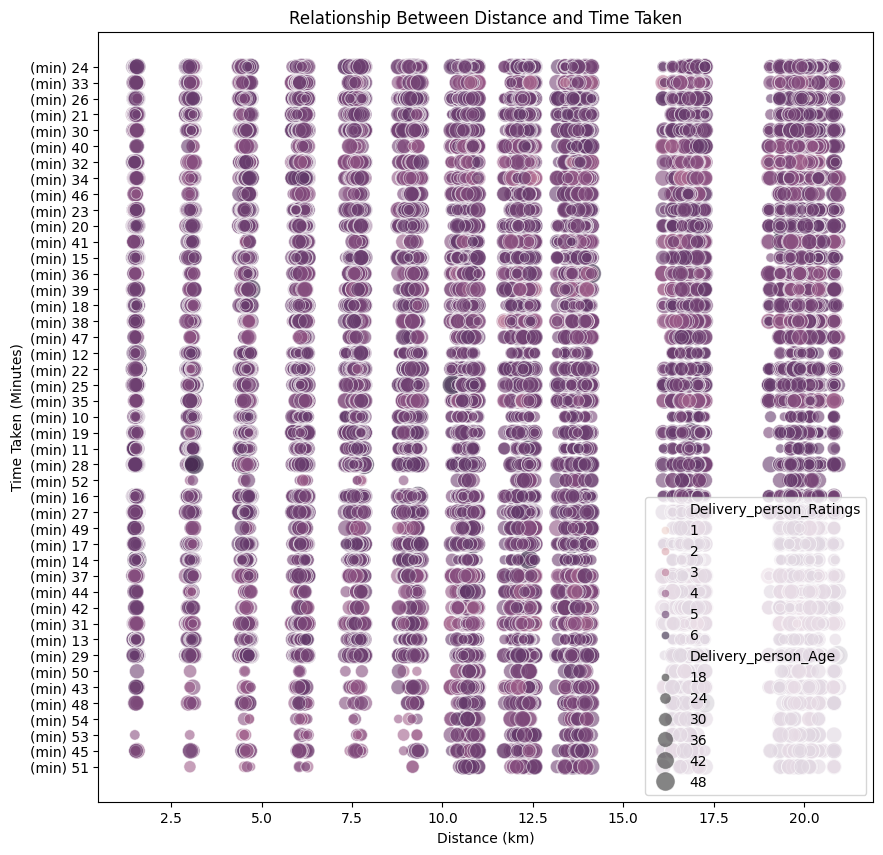

In [272]:
#df['distance'] = np.zeros(len(df))
#restaurant_coordinates = df[['Restaurant_latitude', 'Restaurant_longitude']].to_numpy()
#delivery_location_coordinates = df[['Delivery_location_latitude', 'Delivery_location_longitude']].to_numpy()

# Calculate distances
#df['distance'] = np.array([geodesic(restaurant, delivery).km for restaurant, delivery in zip(restaurant_coordinates, delivery_location_coordinates)])

# Scatter Plot
plt.figure(figsize=(10, 10))
sns.scatterplot(x='distance', y='Time_taken(min)', data=df, hue='Delivery_person_Ratings', size='Delivery_person_Age', sizes=(20, 200), alpha=0.6)
plt.title('Relationship Between Distance and Time Taken')
plt.xlabel('Distance (km)')
plt.ylabel('Time Taken (Minutes)')
plt.show()

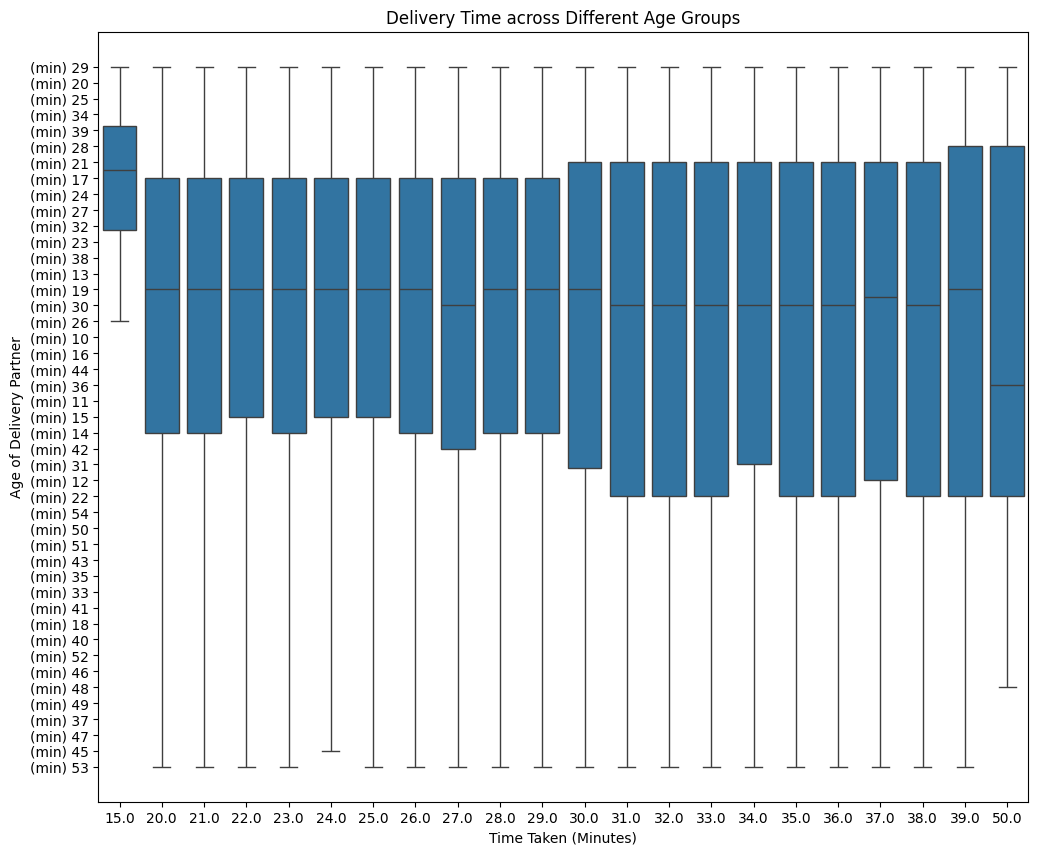

In [273]:
plt.figure(figsize=(12, 10))
sns.boxplot(x='Delivery_person_Age', y='Time_taken(min)', data=df, orient= 'v')
plt.title('Delivery Time across Different Age Groups')
plt.ylabel('Age of Delivery Partner')
plt.xlabel('Time Taken (Minutes)')
plt.show()

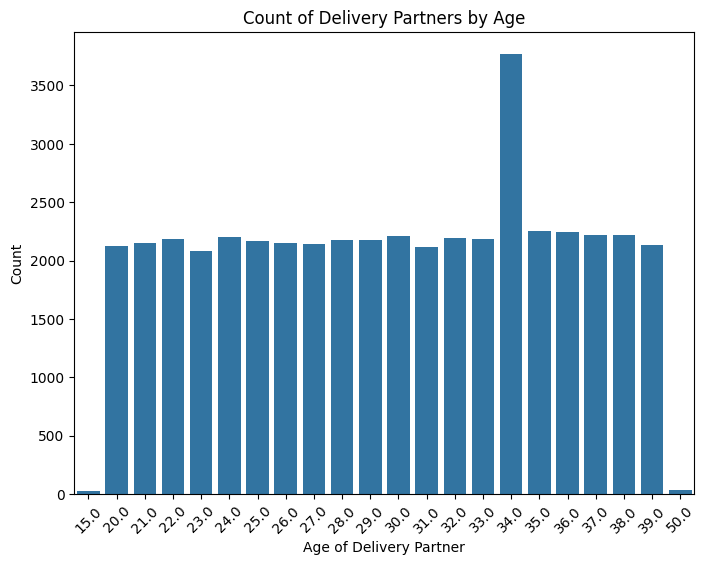

In [274]:
# Countplot of Delivery Partners' Age
plt.figure(figsize=(8, 6))
sns.countplot(x='Delivery_person_Age', data=df)
plt.title('Count of Delivery Partners by Age')
plt.xlabel('Age of Delivery Partner')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

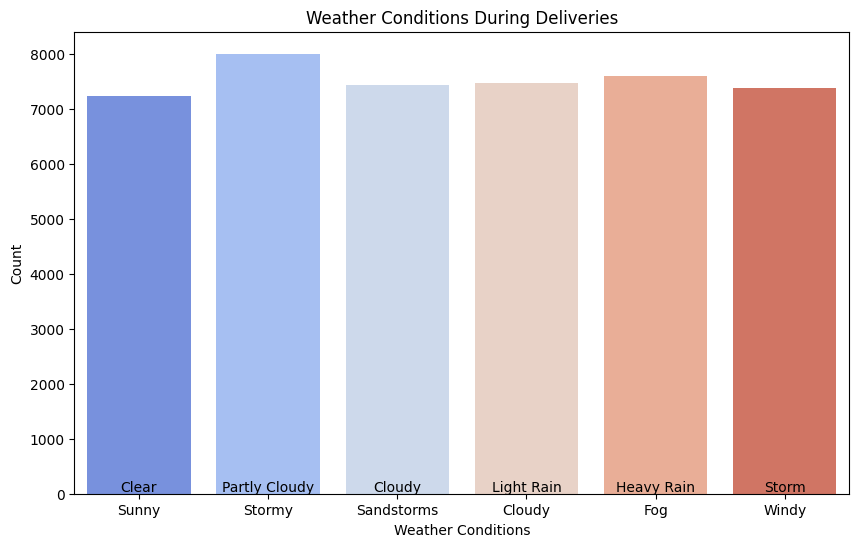

In [275]:
# Dictionary to map the weather conditions to human-readable labels
weather_mapping = {
    0: 'Clear',
    1: 'Partly Cloudy',
    2: 'Cloudy',
    3: 'Light Rain',
    4: 'Heavy Rain',
    5: 'Storm'
}

# Create the bar plot with count of weather conditions
plt.figure(figsize=(10, 6))
sns.countplot(x='Weather_conditions', data=df, palette='coolwarm')

# Adding title and labels
plt.title('Weather Conditions During Deliveries')
plt.xlabel('Weather Conditions')
plt.ylabel('Count')
# Annotating the weather condition labels on the x-axis
for index, label in weather_mapping.items():
    plt.text(index, 50, label, horizontalalignment='center', fontsize=10, color='black')



plt.show()

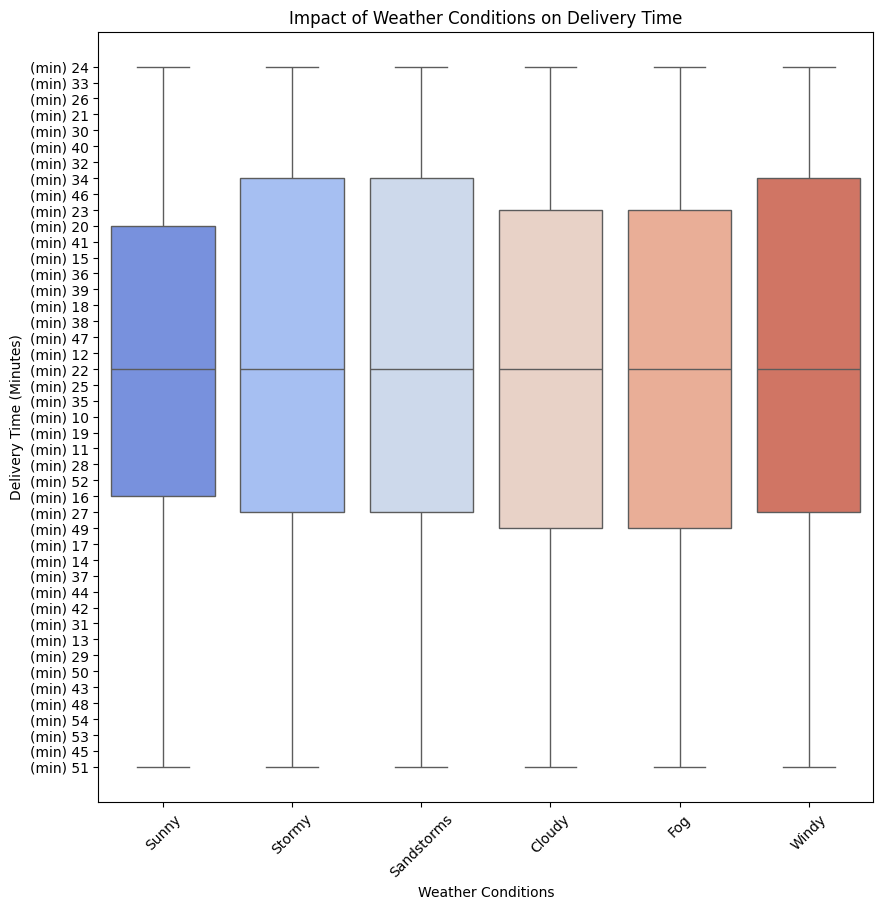

In [276]:
# Creating the boxplot
plt.figure(figsize=(10, 10))
sns.boxplot(x='Weather_conditions', y='Time_taken(min)', data=df, palette="coolwarm")

# Adding title and labels
plt.title('Impact of Weather Conditions on Delivery Time')
plt.xlabel('Weather Conditions')
plt.ylabel('Delivery Time (Minutes)')



plt.xticks(rotation=45)
plt.show()

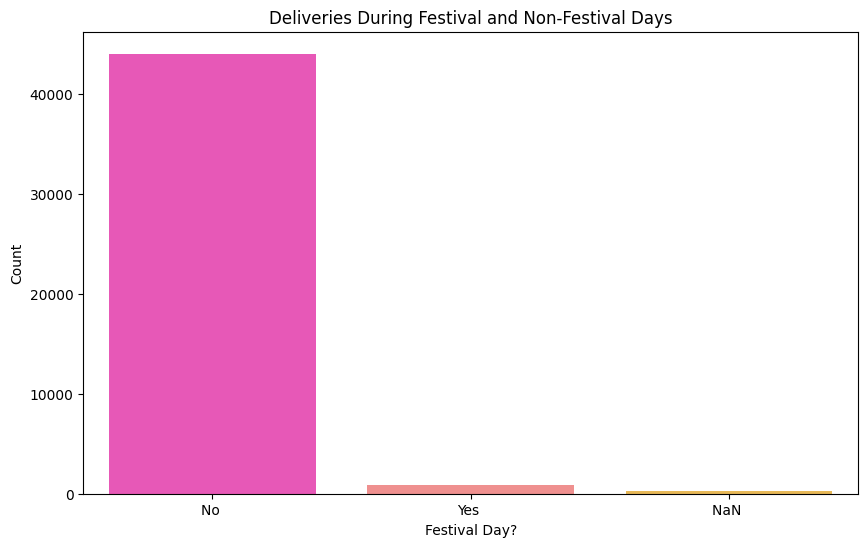

In [277]:
# Countplot - Deliveries During Festival Days
plt.figure(figsize=(10, 6))
sns.countplot(x='Festival', data=df, palette='spring')
plt.title('Deliveries During Festival and Non-Festival Days')
plt.xlabel('Festival Day?')
plt.ylabel('Count')
plt.show()


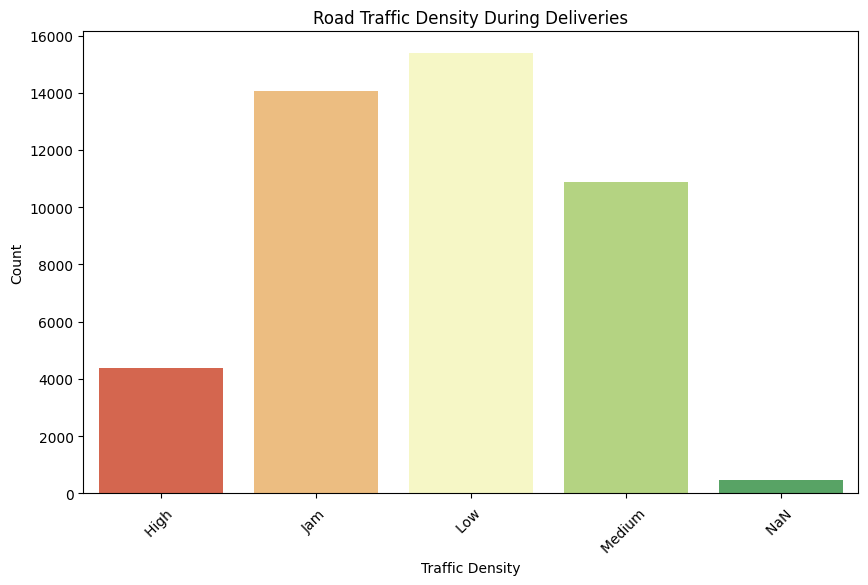

In [278]:
# Countplot - Road Traffic Density During Deliveries
plt.figure(figsize=(10, 6))
sns.countplot(x='Road_traffic_density', data=df, palette='RdYlGn')
plt.title('Road Traffic Density During Deliveries')
plt.xlabel('Traffic Density')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

**LABEL ENCODING**

In [279]:
# Apply Label Encoding as before
categorical_columns = df.select_dtypes(include='object').columns
label_encoder = LabelEncoder()
df[categorical_columns] = df[categorical_columns].apply(lambda col: label_encoder.fit_transform(col))

# Display first few rows of the DataFrame with encoded values
print(df[categorical_columns].head())


   Road_traffic_density  Type_of_order  Type_of_vehicle  Festival  City  \
0                     0              3                2         1     3   
1                     1              3                3         1     0   
2                     2              1                2         1     3   
3                     3              0                2         1     0   
4                     0              3                3         1     0   

   Time_taken(min)  Weather_conditions  City_code  
0               14                   4         10  
1               23                   3          3  
2               16                   2          3  
3               11                   4          6  
4               20                   0          5  


**TRAIN TEST SPLIT**

In [280]:
df.columns

Index(['Delivery_person_Age', 'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Road_traffic_density',
       'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle',
       'multiple_deliveries', 'Festival', 'City', 'Time_taken(min)',
       'Weather_conditions', 'City_code', 'day', 'month', 'quarter', 'year',
       'day_of_week', 'is_month_start', 'is_month_end', 'is_quarter_start',
       'is_quarter_end', 'is_year_start', 'is_year_end', 'is_weekend',
       'order_prepare_time', 'distance'],
      dtype='object')

In [281]:
#Split features & label
X = df.drop('Time_taken(min)', axis=1)   # Features
y = df['Time_taken(min)']  # Target variable

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(36129, 29)
(36129,)
(9033, 29)
(9033,)


In [282]:
print(df.dtypes[['Delivery_person_Age', 'Time_taken(min)', 'distance']])

Delivery_person_Age    float64
Time_taken(min)          int64
distance               float64
dtype: object


In [309]:
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [310]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Find the best model
models = [
    RandomForestRegressor(),
    xgb.XGBRegressor(),
]

param_grid = [
    {'n_estimators': [100, 200, 300]},
    {'n_estimators': [20, 25, 30], 'max_depth': [5, 7, 9]},
]

for i, model in enumerate(models):
    grid_search = GridSearchCV(model, param_grid[i], cv=5, scoring='r2',n_jobs=-1,verbose=1)
    grid_search.fit(X_train, y_train)

    print(f"{model.__class__.__name__}:")
    print("Best parameters:", grid_search.best_params_)
    print("Best R2 score:", grid_search.best_score_)
    print()

Fitting 5 folds for each of 3 candidates, totalling 15 fits
RandomForestRegressor:
Best parameters: {'n_estimators': 300}
Best R2 score: 0.8216462146704643

Fitting 5 folds for each of 9 candidates, totalling 45 fits
XGBRegressor:
Best parameters: {'max_depth': 7, 'n_estimators': 20}
Best R2 score: 0.8261088371276856



In [311]:
# Create a XGB regressor model
model = xgb.XGBRegressor(n_estimators=20,max_depth=9)

# Fit the model on the training data
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [312]:
# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", round(mae,2))
print("Mean Squared Error (MSE):", round(mse,2))
print("Root Mean Squared Error (RMSE):", round(rmse,2))
print("R-squared (R2) Score:", round(r2,2))

Mean Absolute Error (MAE): 3.08
Mean Squared Error (MSE): 15.02
Root Mean Squared Error (RMSE): 3.88
R-squared (R2) Score: 0.83


In [315]:
import pickle

# Assuming 'model' is your trained model
with open('delivery_time_model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("✅ Model saved successfully as 'delivery_time_model.pkl'")


✅ Model saved successfully as 'delivery_time_model.pkl'


In [316]:
import os
print(os.getcwd())


/content


Enter Age of Delivery Partner: 34
Enter Total Distance (in km): 16
Is there a Festival? (Yes/No): No
Enter Weather Condition (0 for "Sunny", 1 for "Cloudy", 2 for "Rainy", 3 for "Foggy", 4 for "Windy"): 1
Predicted Delivery Time in Minutes: 17.48
